**With Traffic light**

Episode 1, Steps: 194, Reward: 2.93
Episode 2, Steps: 194, Reward: 2.93
Episode 3, Steps: 194, Reward: 2.93
Episode 4, Steps: 194, Reward: 2.93
Episode 5, Steps: 194, Reward: 2.93
Episode 6, Steps: 194, Reward: 2.93
Episode 7, Steps: 194, Reward: 2.93
Episode 8, Steps: 194, Reward: 2.93
Episode 9, Steps: 194, Reward: 2.93
Episode 10, Steps: 194, Reward: 2.93


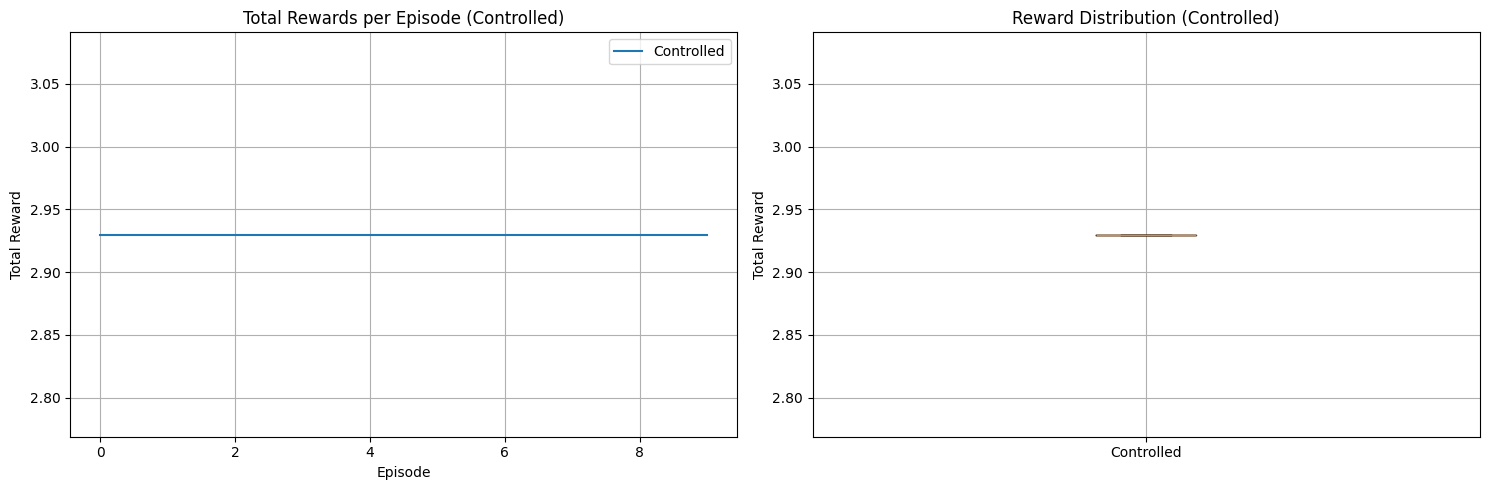

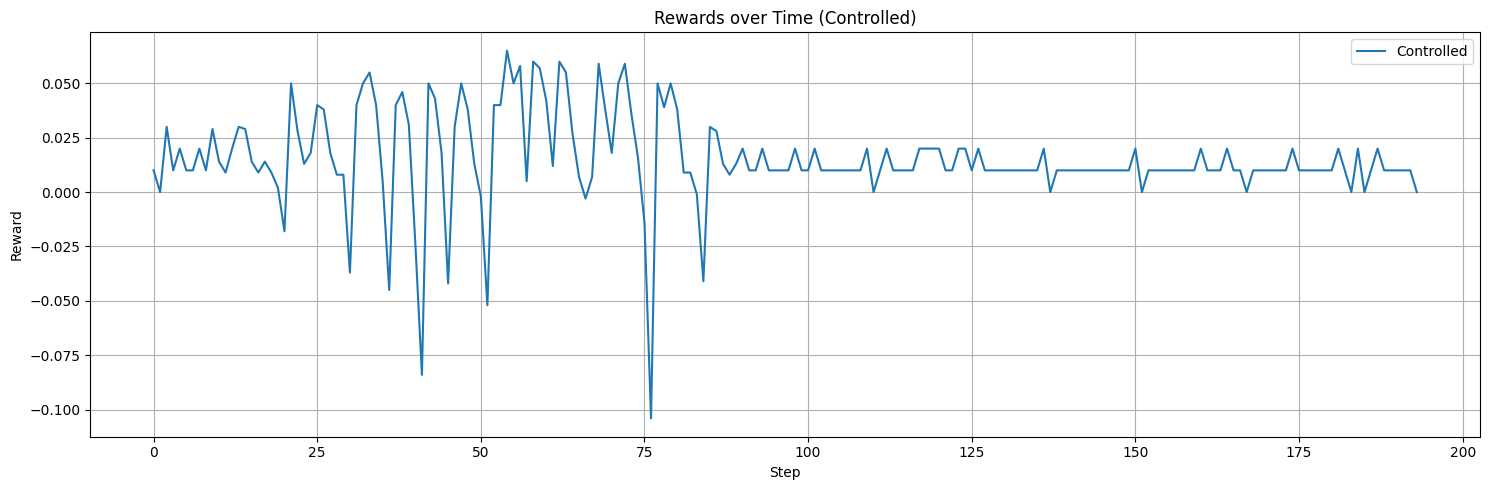

In [8]:
from env import RampMeteringEnv
import numpy as np
import traci
import matplotlib.pyplot as plt

def evaluate_policy(env, q_table_path, episodes=10):
    # Load Q-table
    q_table = np.load(q_table_path, allow_pickle=True).item()
    
    results = []
    traffic_metrics = []
    rewards_over_time = []
    
    for episode in range(episodes):
        if not env.start_simulation():
            continue
            
        state = env.get_state()
        total_reward = 0
        step = 0
        episode_metrics = []
        episode_rewards = []
        
        while step < 1000:
            if state in q_table:
                action = np.argmax(q_table[state])
            else:
                action = np.random.randint(4)
            next_state, reward, done = env.take_action(action)
            
            # Process results
            reward = reward / 1000.0  # Normalize
            total_reward += reward
            episode_rewards.append(reward)
            
            # Collect metrics
            metrics = {
                'step': step,
                'highway_density': traci.edge.getLastStepVehicleNumber(env.highway),
                'ramp_queue': traci.edge.getLastStepHaltingNumber(env.ramp),
                'highway_speed': traci.edge.getLastStepMeanSpeed(env.highway),
                'wait_time': traci.edge.getWaitingTime(env.ramp),
                'reward': reward
            }
            episode_metrics.append(metrics)
            
            state = next_state
            
            # Check congestion
            if metrics['highway_density'] > 50 or metrics['ramp_queue'] > 20:
                done = True
            
            step += 1
            if done:
                break
        
        traci.close()
        results.append(total_reward)
        traffic_metrics.append(episode_metrics)
        rewards_over_time.append(episode_rewards)
        
        print(f"Episode {episode+1}, Steps: {step}, Reward: {total_reward:.2f}")
    
    return results, traffic_metrics, rewards_over_time

# Test controlled scenario
env_controlled = RampMeteringEnv(use_traffic_light=True)
controlled_results, controlled_metrics, controlled_rewards_over_time = evaluate_policy(env_controlled, "trained_q_table.npy")

# Visualize results for controlled scenario
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(controlled_results, label='Controlled')
plt.title('Total Rewards per Episode (Controlled)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot([controlled_results], labels=['Controlled'])
plt.title('Reward Distribution (Controlled)')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.savefig('evaluation_results_controlled.png')
plt.show()

# Visualize rewards over time for the last episode (Controlled)
plt.figure(figsize=(15, 5))
plt.plot(controlled_rewards_over_time[-1], label='Controlled')
plt.title('Rewards over Time (Controlled)')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('rewards_over_time_controlled.png')
plt.show()

**Without Traffic light**

Evaluating trained policy without traffic lights...
Evaluation Total Reward: 10662
Average Ramp Waiting Time: 1.85 seconds
Traffic Flow Efficiency (Vehicles/hour): 4.29


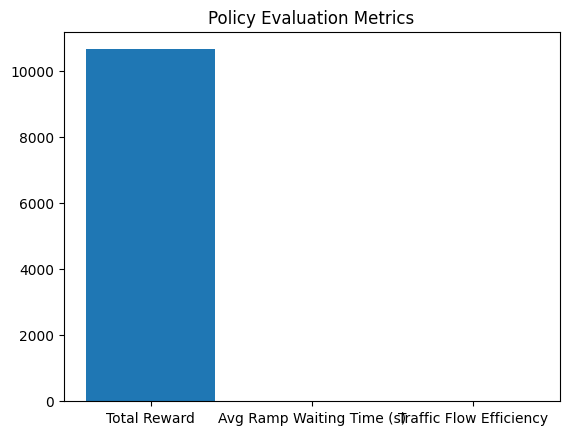

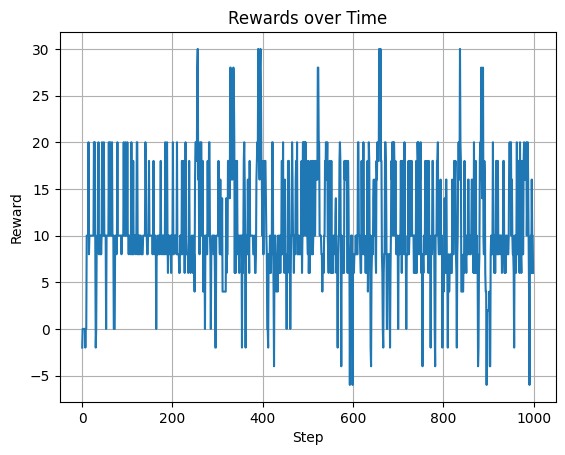

In [10]:
import numpy as np
import traci
import matplotlib.pyplot as plt

# Q-Learning Parameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.9  # Discount factor
EPSILON = 0.1  # Exploration-exploitation balance
EPSILON_DECAY = 0.99
MIN_EPSILON = 0.01
MAX_EPISODES = 20
MAX_STEPS = 1000
NUM_ACTIONS = 4  # Number of actions (e.g., 0: 200, 1: 400, 2: 600, 3: 800)

# Environment Setup
SUMO_CMD = ["sumo", "-c", "D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"]

# State representation function
def get_state():
    highway_density = traci.edge.getLastStepVehicleNumber("2to3")
    ramp_queue = traci.edge.getLastStepHaltingNumber("intramp")
    return (highway_density, ramp_queue)

# Discretize state space (example)
def discretize_state(highway_density, ramp_queue):
    highway_bucket = min(highway_density // 5, 19)  # Increase granularity
    ramp_bucket = min(ramp_queue // 1, 19)  # Increase granularity
    return highway_bucket * 20 + ramp_bucket

# Reward function
def compute_reward(highway_density, ramp_queue):
    throughput = traci.edge.getLastStepVehicleNumber("2to3") * 10
    waiting_penalty = ramp_queue * 2
    return throughput - waiting_penalty  # Reward throughput, penalize queue

# Step function to advance the simulation
def step_simulation(action):
    flow_rates = [200, 400, 600, 800]
    traci.edge.setMaxSpeed("intramp", flow_rates[action]/3600)
    
    traci.simulationStep()
    highway_density = traci.edge.getLastStepVehicleNumber("2to3")
    ramp_queue = traci.edge.getLastStepHaltingNumber("intramp")
    next_state = discretize_state(highway_density, ramp_queue)
    reward = compute_reward(highway_density, ramp_queue)
    done = traci.simulation.getMinExpectedNumber() == 0

    return next_state, reward, done

# Policy evaluation function
def evaluate_policy():
    Q_table = np.load("trained_with_no_traffic_light_q_table.npy")
    traci.start(SUMO_CMD)
    state = discretize_state(*get_state())
    total_reward = 0
    total_ramp_waiting_time = 0
    total_vehicle_throughput = 0
    step = 0
    rewards = []

    while step < MAX_STEPS:
        action = np.argmax(Q_table[state])
        next_state, reward, done = step_simulation(action)
        total_reward += reward
        rewards.append(reward)

        # Collect metrics
        ramp_waiting_time = traci.edge.getWaitingTime("intramp")
        total_ramp_waiting_time += ramp_waiting_time
        highway_throughput = traci.edge.getLastStepVehicleNumber("2to3")
        ramp_throughput = traci.edge.getLastStepVehicleNumber("intramp")
        total_vehicle_throughput += (highway_throughput + ramp_throughput)

        state = next_state
        step += 1

        if done:
            break

    traci.close()

    avg_ramp_waiting_time = total_ramp_waiting_time / step
    avg_vehicle_throughput = total_vehicle_throughput / step

    print(f"Evaluation Total Reward: {total_reward}")
    print(f"Average Ramp Waiting Time: {avg_ramp_waiting_time:.2f} seconds")
    print(f"Traffic Flow Efficiency (Vehicles/hour): {avg_vehicle_throughput:.2f}")

    # Visualization: Metrics
    metrics = [total_reward, avg_ramp_waiting_time, avg_vehicle_throughput]
    metric_names = ["Total Reward", "Avg Ramp Waiting Time (s)", "Traffic Flow Efficiency"]

    plt.figure()
    plt.bar(metric_names, metrics)
    plt.title("Policy Evaluation Metrics")
    plt.show()

    # Visualization: Rewards over time
    plt.figure()
    plt.plot(range(len(rewards)), rewards)
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.title("Rewards over Time")
    plt.grid(True)
    plt.show()

# Evaluation phase
print("Evaluating trained policy without traffic lights...")
evaluate_policy()